# Parcels Experiment: Postprocessing<br><br>Expanding the polyline code to release particles at density based on local velocity normal to section.

_(Based on an experiment originally designed by Christina Schmidt.)_

_(Runs on GEOMAR Jupyter Server at https://schulung3.geomar.de/user/workshop007/lab)_

In [1]:
import xarray as xr
import numpy as np
from glob import glob

In [2]:
list_output = sorted(glob('/gxfs_work1/geomar/smomw360/spg_fresh_blob_202104/data/raw/*backward*.nc'))
list_output_dates = [w[95:103] for w in list_output]

In [3]:
list_all_dates = []
for year in range(1990, 2020):
    for month_day in ['01-03','01-08','01-13','01-18','01-23','01-28','02-02','02-07','02-12','02-17',
                      '02-22','02-28','03-04','03-09','03-14','03-19','03-24','03-29','04-03','04-08',
                      '04-13','04-18','04-23','04-28','05-03','05-08','05-13','05-18','05-23','05-28',
                      '06-02','06-07','06-12','06-17','06-22','06-27','07-02','07-07','07-12','07-17',
                      '07-22','07-27','08-01','08-06','08-11','08-16','08-21','08-26','08-31','09-05',
                      '09-10','09-15','09-20','09-25','09-30','10-05','10-10','10-15','10-20','10-25',
                      '10-30','11-04','11-09','11-14','11-19','11-24','11-29','12-04','12-09','12-14',
                      '12-19','12-24','12-29']:
        if list_all_dates == []:
            list_all_dates = [str(year) + month_day[:2] + month_day[-2:]]
        else:
            list_all_dates.append(str(year) + month_day[:2] + month_day[-2:])

In [4]:
list_output_dates[:13]

['19900103',
 '19900108',
 '19900113',
 '19900118',
 '19900123',
 '19900128',
 '19900202',
 '19900207',
 '19900212',
 '19900217',
 '19900222',
 '19900228',
 '19900304']

In [5]:
list_output_dates[-13:]

['20191030',
 '20191104',
 '20191109',
 '20191114',
 '20191119',
 '20191124',
 '20191129',
 '20191204',
 '20191209',
 '20191214',
 '20191219',
 '20191224',
 '20191229']

In [6]:
list_all_dates[:13]

['19900103',
 '19900108',
 '19900113',
 '19900118',
 '19900123',
 '19900128',
 '19900202',
 '19900207',
 '19900212',
 '19900217',
 '19900222',
 '19900228',
 '19900304']

In [7]:
list_all_dates[-13:]

['20191030',
 '20191104',
 '20191109',
 '20191114',
 '20191119',
 '20191124',
 '20191129',
 '20191204',
 '20191209',
 '20191214',
 '20191219',
 '20191224',
 '20191229']

In [8]:
list_missing = set(list_all_dates).difference(list_output_dates)

In [9]:
list_missing

{'20000309', '20030821'}

In [10]:
list_missing_formatted = [(w[:4] + str('-') + w[4:6]+ str('-') + w[6:8])
                          for w in list_missing]

In [11]:
list_missing_formatted

['2003-08-21', '2000-03-09']

In [12]:
len(list_missing_formatted)

2

## Convert to zarr

In [3]:
%%time
for release_year in range(2000, 2010):
    print(release_year)
    path_zarr = ('/gxfs_work1/geomar/smomw360/spg_fresh_blob_202104/data/raw/' +
                 'tracks_randomvel_mxl_osnap_backwards_' + str(release_year) + '.zarr')
    path_zarr_subset = ('/gxfs_work1/geomar/smomw360/spg_fresh_blob_202104/data/raw/' +
                        'tracks_randomvel_mxl_osnap_backwards_' + str(release_year) + '_subset.zarr')

    files_output = sorted(glob('/gxfs_work1/geomar/smomw360/spg_fresh_blob_202104/data/raw/*backward_' +
                               str(release_year) + '*.nc'))

    ds = xr.open_mfdataset(files_output, concat_dim='traj', combine='nested').chunk({'traj': 60000})

    # cast to lower precision data types    
    ds["z"] = ds["z"].astype("float32")
    ds["lat"] = ds["lat"].astype("float32")
    ds["lon"] = ds["lon"].astype("float32")
    ds = ds.drop(["trajectory", ])

    if release_year == 2016:
        ds.to_zarr(path_zarr, mode='w')

    np.random.seed(1234)
    index_traj = np.random.choice(np.arange(ds.traj.size), 400_000, replace=False)
    ds_subset = ds.isel(traj=np.sort(index_traj)).chunk({'traj': 6000})

    ds_subset.to_zarr(path_zarr_subset, mode='w')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
CPU times: user 22min 50s, sys: 26min 29s, total: 49min 20s
Wall time: 23min 46s


In [4]:
ds_reread = xr.open_zarr(path_zarr_subset)

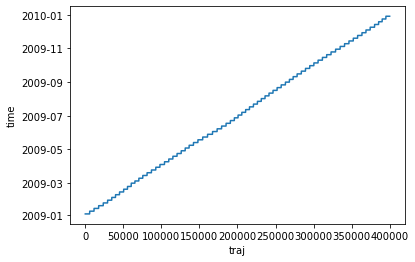

In [5]:
ds_reread.time[:, 0].plot()

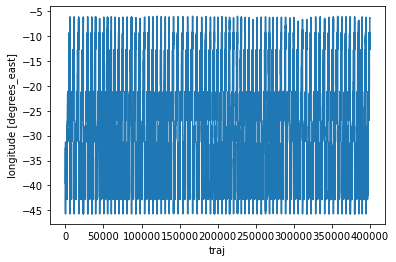

In [6]:
ds_reread.lon[:, 0].plot()